In [1]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
from helper.embedding_matrix import build_embd_matrix

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
data_pair = to_token_tag_list(train_data)

In [5]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [6]:
df = list_to_dataframe(merged_data)
words = get_unique_words(df)
tags = get_unique_tags(df)

In [7]:
w_idx = word2idx(words, 1)
num_words = len(w_idx)
num_tags = len(tags)
max_len = 100

In [8]:
filename = "../word2vec/w2v_skip_gram.txt"

In [9]:
embedding_matrix = build_embd_matrix(filename=filename, w_idx=w_idx)

In [10]:
model = blstm_w2v_model(num_words, num_tags, max_len, embedding_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         58880     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           903       
 ibuted)                                                         
                                                             

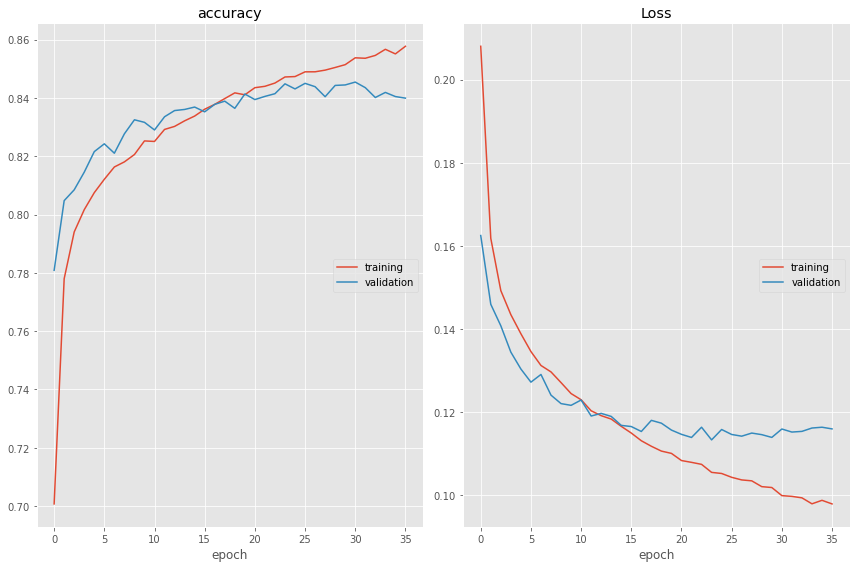

accuracy
	training         	 (min:    0.701, max:    0.858, cur:    0.858)
	validation       	 (min:    0.781, max:    0.845, cur:    0.840)
Loss
	training         	 (min:    0.098, max:    0.208, cur:    0.098)
	validation       	 (min:    0.113, max:    0.163, cur:    0.116)

Epoch 36: val_loss did not improve from 0.11335
56/56 [==============================] - 1s 16ms/step - loss: 0.1159 - accuracy: 0.8378
[0.11590354889631271, 0.837810754776001]


In [11]:
root_path = 'model/'
model_name = 'w2v_sg_blstm_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [12]:
from keras.models import load_model

mdl = load_model('model/w2v_sg_blstm_model.h5')

In [13]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    p = mdl.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            # print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [14]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.8474    0.9323    0.8878     22310
          JV     0.7622    0.8486    0.8030      4913
          EN     0.8649    0.6686    0.7542      5018
   MIX-ID-EN     0.9130    0.4532    0.6058       973
   MIX-ID-JV     0.7500    0.3536    0.4806       280
   MIX-JV-EN     0.9000    0.4874    0.6323       277
           O     0.8549    0.7802    0.8158     10153

    accuracy                         0.8405     43924
   macro avg     0.8418    0.6463    0.7114     43924
weighted avg     0.8428    0.8405    0.8360     43924



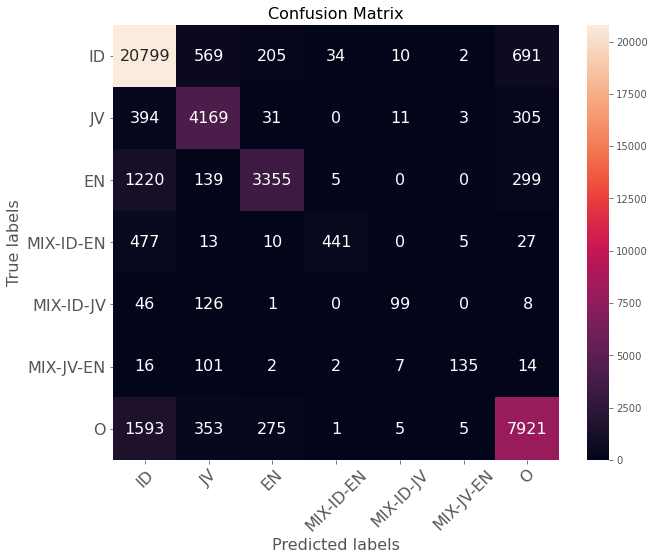

In [15]:
performance_report(true_flat, pred_flat)

In [16]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)
true_pred_file = 'tagging_result/compare_results_w2v_sg.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")

    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()

In [17]:
i = np.random.randint(0, X_test.shape[0])  #659
p = mdl.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" * 60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w - 1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w - 1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
Belajar                       ID        	O
bisnis                        ID        	ID
dari                          ID        	ID
hal                           ID        	ID
kecil                         ID        	ID
:Dv"@IrfanFFU:                O         	JV
bisnis                        ID        	ID
ngeprintke                    MIX-JV-EN 	MIX-JV-EN
tugas                         ID        	ID
e                             JV        	JV
koncone                       JV        	JV
:3"                           O         	JV


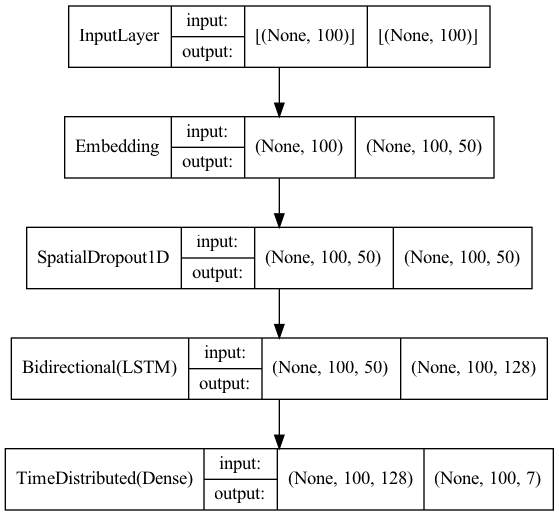

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_w2v_sg_blstm.png', show_shapes=True, show_layer_names=False)